In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import joblib

In [2]:
from py.utils import verifyDir

In [3]:
DATA_PATH = "data/PlacePulse_2/"

QSCORE_PATH = f"{DATA_PATH}/Qscores/all/Summaries/"
MAIN_OUT_PATH = "outputs/"
CACHE_PATH = f"{MAIN_OUT_PATH}/cache/"

In [4]:
verifyDir(CACHE_PATH)

### Generating samples 

In [5]:
data_dict = joblib.load(f"{MAIN_OUT_PATH}/static/data_model.joblib")
data_dict.keys()

dict_keys(['id', 'features', 'features_name', 'safety', 'label', 'latitude', 'longitude', 'city', 'country', 'continent', 'path'])

In [85]:
feature_names = np.array(data_dict["features_name"]).copy()
y = np.array(data_dict["safety"]).copy()
X = np.array(data_dict["features"]).copy()
X.shape, y.shape

((110988, 19), (110988,))

### Standard Scaler

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
scaler = StandardScaler()

In [9]:
from sklearn.preprocessing import Normalizer

In [10]:
normalizer = Normalizer()

### Classifiers

In [11]:
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [12]:
regularizer_value = np.logspace(-3, 3, num=7)
type_scaler = ['passthrough', scaler, normalizer]
# dim_reductor = [t_svd, pca, sparse_pca]
random_state = 42
max_iter=2000

In [13]:
lr = LinearRegression()

param_lr = {}
param_lr['scaler'] = copy.deepcopy(type_scaler)
#param_lr['dim_reductor'] = copy.deepcopy(dim_reductor)
param_lr['regressor'] = [lr]

In [14]:
lasso = Lasso(
    tol=1e-3,
    random_state=random_state,
    max_iter=max_iter,
)

param_lasso = {}
param_lasso['scaler'] = copy.deepcopy(type_scaler)
# param_ridge['dim_reductor'] = copy.deepcopy(dim_reductor)
param_lasso['regressor__alpha'] = copy.deepcopy(regularizer_value)
param_lasso['regressor'] = [lasso]

In [15]:
ridge = Ridge(
    tol=1e-3,
    random_state=random_state,
    max_iter=max_iter,
)

param_ridge = {}
param_ridge['scaler'] = copy.deepcopy(type_scaler)
# param_ridge['dim_reductor'] = copy.deepcopy(dim_reductor)
param_ridge['regressor__alpha'] = copy.deepcopy(regularizer_value)
param_ridge['regressor'] = [ridge]

In [16]:
linear_svm = LinearSVR(
    tol=1e-3,
    random_state=random_state,
    max_iter=max_iter,
)

param_linear_svm = {}
param_linear_svm['scaler'] = copy.deepcopy(type_scaler)
# param_linear_svm['dim_reductor'] = copy.deepcopy(dim_reductor)
param_linear_svm['regressor__C'] = copy.deepcopy(regularizer_value)
param_linear_svm['regressor__loss'] = ["epsilon_insensitive", "squared_epsilon_insensitive"]
param_linear_svm['regressor'] = [linear_svm]

In [17]:
svm = SVR(
    tol=1e-3,
    max_iter=max_iter,
)

param_svm = {}
param_svm['scaler'] = copy.deepcopy(type_scaler)
# param_linear_svm['dim_reductor'] = copy.deepcopy(dim_reductor)
param_svm['regressor__C'] = copy.deepcopy(regularizer_value)
param_svm['regressor__gamma'] = ["scale", "auto"]
param_svm['regressor__kernel'] = ["linear", "poly", "rbf"]
param_svm['regressor'] = [svm]

In [18]:
ds_tree = DecisionTreeRegressor(random_state=random_state)

param_tree = {}
param_tree["scaler"] = copy.deepcopy(type_scaler)
param_tree['regressor__max_features'] = [None, 'sqrt']
param_tree['regressor__max_depth'] = np.append(None, np.arange(10, 110, 10) )
param_tree['regressor__min_samples_split'] = np.arange(3, 7)
param_tree['regressor__min_samples_leaf'] = np.arange(3, 7)
param_tree['regressor__criterion'] = ["squared_error", "friedman_mse", "absolute_error", "poisson"]
param_tree['regressor'] = [ds_tree]

### Create Pipeline

In [19]:
from joblib import Memory

In [20]:
memory = Memory(
    location=CACHE_PATH,
    # verbose=1,
)

In [21]:
from sklearn.pipeline import Pipeline

In [22]:
pipeline = Pipeline(
    steps = [
        # 1. Scaler
        ('scaler', scaler),
        # 3. Model selecction
        ('regressor', lr),
    ],
    memory=memory,
)

### Metrics

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from scipy.stats import pearsonr

In [24]:
def adj_r2_score(estimator, X, y_true):
    n, p = X.shape
    pred = estimator.predict(X)
    return 1 - ((1 - r2_score(y_true, pred)) * (n - 1))/(n-p-1)

In [25]:
def pearson_score(y_true, y_pred):
    corr, _ = pearsonr(y_true, y_pred)
    return corr

### Create GridSearch

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
param_grid = [param_lr, 
              param_lasso,
              param_ridge,
              param_linear_svm,
              param_svm,
              #param_tree,
             ]

In [28]:
param_grid

[{'scaler': ['passthrough', StandardScaler(), Normalizer()],
  'regressor': [LinearRegression()]},
 {'scaler': ['passthrough', StandardScaler(), Normalizer()],
  'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'regressor': [Lasso(max_iter=2000, random_state=42, tol=0.001)]},
 {'scaler': ['passthrough', StandardScaler(), Normalizer()],
  'regressor__alpha': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'regressor': [Ridge(max_iter=2000, random_state=42, tol=0.001)]},
 {'scaler': ['passthrough', StandardScaler(), Normalizer()],
  'regressor__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'regressor__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
  'regressor': [LinearSVR(max_iter=2000, random_state=42, tol=0.001)]},
 {'scaler': ['passthrough', StandardScaler(), Normalizer()],
  'regressor__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'regressor__gamma': ['scale', 

In [29]:
grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring=make_scorer(pearson_score),
            refit=True,
            cv=5,  # << Use time series
            verbose=4,
)

In [30]:
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=outputs//cache/joblib),
                                steps=[('scaler', StandardScaler()),
                                       ('regressor', LinearRegression())]),
             param_grid=[{'regressor': [LinearRegression()],
                          'scaler': ['passthrough', StandardScaler(),
                                     Normalizer()]},
                         {'regressor': [Lasso(max_iter=2000, random_state=42,
                                              tol=0.001)],
                          'regressor__alpha': array([1.e-03,...
                                              'squared_epsilon_insensitive'],
                          'scaler': ['passthrough', StandardScaler(),
                                     Normalizer()]},
                         {'regressor': [SVR(max_iter=2000)],
                          'regressor__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'regressor__gamma': ['scale', 'auto'],
                          'regressor__kernel': ['linear', 'poly', 'rbf'],
                          'scaler': ['passthrough', StandardScaler(),
                                     Normalizer()]}],
             scoring=make_scorer(pearson_score), verbose=4)

### Data Split

In [31]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(X, 
                                                y, 
                                                train_size=0.75, 
                                                random_state=random_state,
                                               )
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(83241, 19) (83241,) (27747, 19) (27747,)


### Training

In [33]:
%%time
regressor = grid_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 213 candidates, totalling 1065 fits
[CV 1/5] END regressor=LinearRegression(), scaler=passthrough;, score=0.279 total time=   0.0s
[CV 2/5] END regressor=LinearRegression(), scaler=passthrough;, score=0.278 total time=   0.0s
[CV 3/5] END regressor=LinearRegression(), scaler=passthrough;, score=0.292 total time=   0.0s
[CV 4/5] END regressor=LinearRegression(), scaler=passthrough;, score=0.283 total time=   0.0s
[CV 5/5] END regressor=LinearRegression(), scaler=passthrough;, score=0.283 total time=   0.0s
[CV 1/5] END regressor=LinearRegression(), scaler=StandardScaler();, score=0.279 total time=   0.0s
[CV 2/5] END regressor=LinearRegression(), scaler=StandardScaler();, score=0.278 total time=   0.0s
[CV 3/5] END regressor=LinearRegression(), scaler=StandardScaler();, score=0.292 total time=   0.0s
[CV 4/5] END regressor=LinearRegression(), scaler=StandardScaler();, score=0.283 total time=   0.0s
[CV 5/5] END regressor=LinearRegression(), scaler=StandardSca

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/fe

[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=passthrough;, score=0.178 total time=   0.0s
[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=N

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/fe

[CV 4/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 3/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 4/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=passthrough;, score=n

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/fe

[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 3/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 4/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scaler=passthroug

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/fe

[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 3/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 4/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 3/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0,

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/fe

[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 3/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 4/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=passthrough;, score=nan total time=   0.0s
[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=StandardScaler();, score=nan total time=   0.0s
[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=St

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/fe

[CV 1/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 2/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 3/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 4/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 5/5] END regressor=Lasso(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=1000.0, scaler=Normalizer();, score=nan total time=   0.0s
[CV 1/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=passthrough;, score=0.279 total time=   0.0s
[CV 2/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=pa

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


[CV 4/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=StandardScaler();, score=0.283 total time=   0.0s
[CV 5/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=StandardScaler();, score=0.283 total time=   0.0s
[CV 1/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=Normalizer();, score=0.285 total time=   0.0s
[CV 2/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=Normalizer();, score=0.287 total time=   0.0s
[CV 3/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=Normalizer();, score=0.299 total time=   0.0s
[CV 4/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.001, scaler=Normalizer();, score=0.294 total time=   0.0s
[CV 5/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=0.

[CV 5/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=StandardScaler();, score=0.283 total time=   0.0s
[CV 1/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=0.284 total time=   0.0s
[CV 2/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=0.286 total time=   0.0s
[CV 3/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=0.299 total time=   0.0s
[CV 4/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=0.294 total time=   0.0s
[CV 5/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=10.0, scaler=Normalizer();, score=0.290 total time=   0.0s
[CV 1/5] END regressor=Ridge(max_iter=2000, random_state=42, tol=0.001), regressor__alpha=100.0, scale

[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.001, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.249 total time=   0.3s
[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.001, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.255 total time=   0.3s
[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.001, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.266 total time=   0.3s
[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.001, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.255 total time=   0.3s
[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.001, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.253 total time=   0.3s
[CV 1/5] END regressor=LinearS

[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.01, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.287 total time=   0.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.275 total time=   5.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.278 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.292 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.277 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.281 total time=   5.3s
[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.277 total time=   0.5s
[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.277 total time=   0.4s
[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.292 total time=   0.5s
[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.280 total time=   0.5s
[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.278 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.278 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.287 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.280 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.280 total time=   8.2s
[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.279 total time=   1.5s
[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.278 total time=   1.5s
[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.292 total time=   1.5s
[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=0.1, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.283 total time=   1.5s
[CV 5/5] END regress

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.246 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.211 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.171 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.239 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.241 total time=   8.3s
[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.278 total time=   3.4s
[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.277 total time=   3.3s
[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.292 total time=   3.4s
[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.283 total time=   3.4s
[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.258 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.184 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.152 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.218 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.222 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.278 total time=  11.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.278 total time=  10.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.292 total time=  10.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.283 total time=  10.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.283 total time=  10.6s
[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.285 total time=   0.2s
[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.287 total time=   0.2s
[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.299 total time=   0.2s
[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.294 total time=   0.2s
[CV 5/5] END regressor=LinearSV

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.248 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.149 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.115 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.214 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.218 total time=   8.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.273 total time=   8.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.272 total time=   8.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.286 total time=   8.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.272 total time=   8.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.268 total time=   8.7s
[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.284 total time=   0.5s
[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.287 total time=   0.5s
[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.300 total time=   0.5s
[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.294 total time=   0.5s
[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, t

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.249 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.153 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.119 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.214 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.218 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.270 total time=  10.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.270 total time=  10.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.284 total time=  10.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.280 total time=  10.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.281 total time=  10.7s
[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.285 total time=   1.2s
[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.287 total time=   1.2s
[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.299 total time=   1.2s
[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=10.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.294 total time=   1.2s
[CV 5/5] END regressor=Lin

/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.247 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.150 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.115 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.214 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.218 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.145 total time=  10.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.115 total time=  10.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.217 total time=  10.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.207 total time=  10.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.195 total time=  10.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.284 total time=   2.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.287 total time=   2.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.300 total time=   2.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.293 total time=   2.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.290 total time=   2.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.247 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.151 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.116 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.214 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.218 total time=   7.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.258 total time=  10.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.184 total time=  10.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.174 total time=  10.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.219 total time=  10.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.217 total time=  10.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.285 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.287 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.299 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.294 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=100.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.291 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.246 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.151 total time=   8.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.116 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.214 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=passthrough;, score=0.218 total time=   8.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.181 total time=  10.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.109 total time=  10.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.154 total time=  10.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.199 total time=  10.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=StandardScaler();, score=0.187 total time=  10.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.275 total time=   7.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.271 total time=   7.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.190 total time=   7.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.275 total time=   7.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=epsilon_insensitive, scaler=Normalizer();, score=0.268 total time=   7.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.246 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.151 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.116 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.214 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=passthrough;, score=0.218 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.189 total time=  10.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.115 total time=  10.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.156 total time=  10.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.200 total time=  10.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=StandardScaler();, score=0.190 total time=  10.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.266 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.217 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.232 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.262 total time=   8.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END regressor=LinearSVR(max_iter=2000, random_state=42, tol=0.001), regressor__C=1000.0, regressor__loss=squared_epsilon_insensitive, scaler=Normalizer();, score=0.263 total time=   8.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.115 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.032 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.082 total time=   4.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.132 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.171 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.102 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.103 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.108 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.101 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.095 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.099 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.092 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.093 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.109 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.101 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.110 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.098 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.101 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.115 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.098 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.014 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.019 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.010 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.003 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=0.004 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.126 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.133 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.134 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.143 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.139 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.108 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.107 total time=   7.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.116 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.123 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.099 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.083 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.072 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.074 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.086 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.059 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.119 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.127 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.131 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.135 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.131 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.115 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.032 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.082 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.132 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.171 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.102 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.103 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.108 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.101 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.095 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.099 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.092 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.093 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.109 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.101 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=0.097 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.183 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.032 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.118 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.114 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.014 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.019 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.010 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.003 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=0.004 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.128 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.131 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.138 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.145 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.140 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.122 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.146 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.129 total time=   9.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.144 total time=   9.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.129 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.083 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.072 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.074 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.086 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.059 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.102 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.092 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.098 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.112 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.001, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.104 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.156 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.129 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.142 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.115 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.109 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.028 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.065 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.069 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.067 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.076 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.094 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.091 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.085 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.103 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.100 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.131 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.114 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.125 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.126 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.108 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.019 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=0.003 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.015 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.007 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.131 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.143 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.153 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.151 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.144 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.112 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.116 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.128 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.125 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.107 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.108 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.085 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.081 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.105 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.080 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.121 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.135 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.130 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.134 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.129 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.156 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.129 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.142 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.115 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.109 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.028 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.065 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.069 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.067 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.076 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.094 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.091 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.085 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.103 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.100 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.064 total time=   3.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.049 total time=   3.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=0.111 total time=   3.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.060 total time=   3.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.080 total time=   3.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.019 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=0.003 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.015 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.007 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.128 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.131 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.138 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.145 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.140 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.125 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.147 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.131 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.145 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.131 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.108 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.085 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.081 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.105 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.080 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.101 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.092 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.096 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.111 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.01, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.103 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.110 total time=   3.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.156 total time=   3.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.017 total time=   3.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.034 total time=   3.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.144 total time=   3.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.004 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.001 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.054 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.064 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.054 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.081 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.115 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.094 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.114 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.070 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.140 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.130 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.155 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.143 total time=   5.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.151 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.014 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.025 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.002 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.022 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.002 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.145 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.164 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.185 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.171 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.150 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.123 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.148 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.150 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.166 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.141 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.122 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.134 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.137 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.153 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.124 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.120 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.144 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.146 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.154 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.151 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.110 total time=   3.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.156 total time=   3.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.017 total time=   3.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.034 total time=   3.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.144 total time=   3.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.004 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.001 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.054 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.064 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.054 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.081 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.115 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.094 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.114 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.070 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.133 total time=   2.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.106 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.119 total time=   2.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.112 total time=   2.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.140 total time=   2.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.014 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.025 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.002 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.022 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.002 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.128 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.131 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.138 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.145 total time=   5.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.140 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.138 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.153 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.141 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.153 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.141 total time=   9.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.122 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.134 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.137 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.153 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.124 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.095 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.093 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.089 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.102 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=0.1, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.102 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.121 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.019 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.100 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.144 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.178 total time=   1.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.036 total time=   4.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.000 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.019 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.043 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.050 total time=   4.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.166 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.113 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.137 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.179 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.116 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.007 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.131 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.038 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.079 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.051 total time=   5.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.020 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.013 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.011 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.079 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.176 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.181 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.141 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.153 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.105 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.120 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.159 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.136 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.086 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.114 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.044 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.108 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.116 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.086 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.174 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.147 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.157 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.164 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.170 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.121 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.019 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.100 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.144 total time=   2.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.178 total time=   1.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.036 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.000 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.019 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.043 total time=   4.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.050 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.166 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.113 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.137 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.179 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.116 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.160 total time=   1.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.024 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.037 total time=   1.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.017 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.082 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.020 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.013 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.011 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.128 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.131 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.137 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.143 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.140 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.140 total time=   9.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.166 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.153 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.162 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.145 total time=   9.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.114 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.044 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.108 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.116 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.086 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.081 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.119 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.101 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.121 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.072 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.147 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.200 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.007 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.012 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.156 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.058 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.007 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.136 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.096 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.086 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.089 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=-0.093 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=-0.023 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.103 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.038 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.139 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.017 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.070 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.076 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.083 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.017 total time=   4.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.022 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.004 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.027 total time=   4.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.011 total time=   4.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.022 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.042 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=-0.133 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=-0.086 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.003 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.090 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.057 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.046 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.025 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.109 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.001 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.038 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.039 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.010 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.018 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.083 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.035 total time=   6.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.133 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.068 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.019 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.147 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.200 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.007 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.012 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.156 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.058 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.007 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.136 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.096 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.086 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.089 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=-0.093 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=-0.023 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.103 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.038 total time=   5.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.041 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.031 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=0.075 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.012 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.101 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.017 total time=   4.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.022 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.004 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.027 total time=   3.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.011 total time=   4.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.125 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.133 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.134 total time=   5.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.143 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.142 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.093 total time=   7.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.116 total time=   7.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.102 total time=   7.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.113 total time=   7.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.103 total time=   7.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.001 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.038 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.039 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.010 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.018 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.108 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.152 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.070 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.168 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=10.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.172 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.072 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.110 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.098 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.002 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.024 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.003 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.011 total time=   1.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.093 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.017 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.056 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=-0.073 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=-0.197 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.034 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.099 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.018 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.084 total time=   4.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.177 total time=   4.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.062 total time=   4.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.031 total time=   4.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.189 total time=   4.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.016 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.036 total time=   2.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.025 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.017 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.024 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.036 total time=   4.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=-0.092 total time=   4.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.107 total time=   4.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.097 total time=   4.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.079 total time=   4.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.063 total time=   7.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=-0.102 total time=   6.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=-0.172 total time=   6.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=-0.131 total time=   6.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.028 total time=   6.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.038 total time=   5.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.121 total time=   5.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.062 total time=   5.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.092 total time=   5.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.005 total time=   5.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=-0.068 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=-0.167 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.058 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.024 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=-0.185 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.072 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.110 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.098 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.002 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.024 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.003 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.011 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.093 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.017 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.056 total time=   1.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=-0.073 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=-0.197 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.034 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.099 total time=   4.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.018 total time=   4.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.056 total time=   1.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.063 total time=   1.0s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.078 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.076 total time=   1.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.165 total time=   1.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.016 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.036 total time=   2.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.025 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.017 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.024 total time=   2.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.131 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.143 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.153 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.154 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.140 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.082 total time=   7.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.102 total time=   7.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.099 total time=   7.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.105 total time=   7.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.107 total time=   7.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.038 total time=   5.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.121 total time=   5.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.062 total time=   5.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.092 total time=   5.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.005 total time=   5.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.021 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.008 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.069 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=-0.002 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=100.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.150 total time=   6.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.186 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.033 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.175 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=0.170 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=passthrough;, score=-0.054 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.106 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.044 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.066 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=0.051 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=StandardScaler();, score=-0.051 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=-0.148 total time=   3.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.052 total time=   3.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.184 total time=   3.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=-0.019 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=linear, scaler=Normalizer();, score=0.009 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=0.045 total time=   3.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.138 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.121 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.123 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=passthrough;, score=-0.053 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.025 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.016 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.016 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=StandardScaler();, score=-0.004 total time=   2.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=-0.009 total time=   4.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.096 total time=   4.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.140 total time=   4.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=0.110 total time=   4.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=poly, scaler=Normalizer();, score=-0.155 total time=   4.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.028 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.001 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=0.121 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=-0.129 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=passthrough;, score=-0.058 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.067 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.033 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.035 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.068 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=StandardScaler();, score=0.095 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=-0.070 total time=   5.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=-0.104 total time=   5.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=-0.000 total time=   5.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=-0.072 total time=   5.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=scale, regressor__kernel=rbf, scaler=Normalizer();, score=0.181 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.186 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.033 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.175 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=0.170 total time=   1.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=passthrough;, score=-0.054 total time=   1.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.106 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.044 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.066 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=0.051 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=StandardScaler();, score=-0.051 total time=   1.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=-0.148 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.052 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.184 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=-0.019 total time=   3.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=linear, scaler=Normalizer();, score=0.009 total time=   3.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.007 total time=   0.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=-0.098 total time=   0.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=0.057 total time=   0.9s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=0.110 total time=   0.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=passthrough;, score=0.124 total time=   0.8s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.025 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.023 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.016 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.016 total time=   2.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=StandardScaler();, score=-0.004 total time=   2.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.132 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.161 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.149 total time=   5.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.171 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=poly, scaler=Normalizer();, score=0.156 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.082 total time=   7.4s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.110 total time=   7.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.099 total time=   7.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.103 total time=   7.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=passthrough;, score=0.107 total time=   7.5s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.067 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.033 total time=   5.3s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.035 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=-0.068 total time=   5.2s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=StandardScaler();, score=0.051 total time=   5.1s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 1/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=-0.049 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.002 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=-0.188 total time=   6.6s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 4/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.046 total time=   6.7s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 5/5] END regressor=SVR(max_iter=2000), regressor__C=1000.0, regressor__gamma=auto, regressor__kernel=rbf, scaler=Normalizer();, score=0.007 total time=   6.7s
CPU times: user 1h 7min 19s, sys: 36 s, total: 1h 7min 55s
Wall time: 1h 7min 47s


/home/felipe/anaconda3/envs/server_PlacePulse/lib/python3.8/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [ 0.28301654  0.28301654  0.29125323  0.28311033  0.28304966  0.28595634
  0.28231215  0.28214038  0.22190875  0.27152742  0.21099096         nan
  0.17376307         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
  0.28301654  0.28301654  0.29125335  0.28301654  0.28301654  0.29125444
  0.28301655  0.28301654  0.29126396  0.28301659  0.28301656  0.29129417
  0.28301704  0.28301675  0.29069115  0.28302134  0.28301795  0.28637864
  0.28304737  0.28298111  0.26484512  0.24551422  0.28299554  0.24475013
  0.25568956  0.28299426  0.26588793  0.27132975  0.28243565  0.28311775
  0.28006681  0.28294874  0.28789509  0.28049223  0.28167517  0.29032863
  0.28067559  0.28301331  0.29107965  0.22166808  0.28228149  0.29102796
  0.20683126  0.2828055

### Results

In [34]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor,param_scaler,param_regressor__alpha,param_regressor__C,param_regressor__loss,param_regressor__gamma,param_regressor__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020439,0.005065,0.001367,0.000252,LinearRegression(),passthrough,NaN,NaN,NaN,NaN,NaN,"{'regressor': LinearRegression(), 'scaler': 'p...",0.278745,0.277893,0.291919,0.283281,0.283244,0.283017,0.004977,34
1,0.031065,0.003865,0.002075,0.000504,LinearRegression(),StandardScaler(),NaN,NaN,NaN,NaN,NaN,"{'regressor': LinearRegression(), 'scaler': St...",0.278745,0.277893,0.291919,0.283281,0.283244,0.283017,0.004977,34
2,0.029096,0.000632,0.001884,0.000035,LinearRegression(),Normalizer(),NaN,NaN,NaN,NaN,NaN,"{'regressor': LinearRegression(), 'scaler': No...",0.285458,0.286501,0.299206,0.294231,0.290870,0.291253,0.005068,7
3,0.090370,0.010711,0.001374,0.000218,"Lasso(max_iter=2000, random_state=42, tol=0.001)",passthrough,0.001,NaN,NaN,NaN,NaN,"{'regressor': Lasso(max_iter=2000, random_stat...",0.278788,0.278229,0.291961,0.283287,0.283287,0.283110,0.004918,19
4,0.073372,0.008529,0.002567,0.000468,"Lasso(max_iter=2000, random_state=42, tol=0.001)",StandardScaler(),0.001,NaN,NaN,NaN,NaN,"{'regressor': Lasso(max_iter=2000, random_stat...",0.278875,0.278060,0.291796,0.283314,0.283203,0.283050,0.004877,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2.091883,0.032752,0.274561,0.012866,SVR(max_iter=2000),StandardScaler(),NaN,1000.0,NaN,auto,poly,"{'regressor': SVR(max_iter=2000), 'regressor__...",-0.024594,-0.023433,-0.016027,-0.016209,-0.004185,-0.016890,0.007277,168
209,4.493754,0.031117,0.829184,0.016098,SVR(max_iter=2000),Normalizer(),NaN,1000.0,NaN,auto,poly,"{'regressor': SVR(max_iter=2000), 'regressor__...",0.132069,0.161173,0.149007,0.170937,0.155846,0.153806,0.013019,78
210,5.859175,0.096157,1.565486,0.031488,SVR(max_iter=2000),passthrough,NaN,1000.0,NaN,auto,rbf,"{'regressor': SVR(max_iter=2000), 'regressor__...",0.082122,0.109952,0.099491,0.103456,0.107038,0.100412,0.009793,114
211,3.968742,0.070779,1.216291,0.006424,SVR(max_iter=2000),StandardScaler(),NaN,1000.0,NaN,auto,rbf,"{'regressor': SVR(max_iter=2000), 'regressor__...",-0.066848,0.032642,-0.034800,-0.068470,0.051361,-0.017223,0.050176,170


In [35]:
grid_search.best_estimator_

Pipeline(memory=Memory(location=outputs//cache/joblib),
         steps=[('scaler', Normalizer()),
                ('regressor',
                 Ridge(max_iter=2000, random_state=42, tol=0.001))])

In [36]:
y_pred = regressor.predict(xtest)
y_pred.shape, pearsonr(ytest, y_pred)

((27747,), PearsonRResult(statistic=0.30067449255095346, pvalue=0.0))

### Saving data to server

In [101]:
data_server = joblib.load(f"{MAIN_OUT_PATH}/static/data_server.joblib")
data_server.keys()

dict_keys(['id', 'features', 'features_name', 'safety', 'label', 'latitude', 'longitude', 'city', 'country', 'continent', 'path', 'prediction'])

In [102]:
y_pred = regressor.predict( np.array(data_server["features"]).copy() )
y_pred.shape

(27784,)

In [104]:
data_server["prediction"] = y_pred.tolist()
data_server["model"] = copy.deepcopy(regressor)

In [105]:
joblib.dump(data_server, f"{MAIN_OUT_PATH}/static/data_server.joblib")

['outputs//static/data_server.joblib']

In [41]:
os.exit()

NameError: name 'os' is not defined

In [ ]:
print(classification_report(
    ytest,
    grid_search.predict(xtest),
    digits=4,
))

### Feature Permutation Importance

In [96]:
def normalize_vector(vector, type_="-1-1"):
    min_val = np.min(vector)
    max_val = np.max(vector)
    if type_=="0-1":
        normalized_vector = (vector - min_val) / (max_val - min_val)
    else:
        normalized_vector = 2 * ((vector - min_val) / (max_val - min_val)) - 1
    return normalized_vector

In [59]:
from sklearn.inspection import permutation_importance

In [79]:
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

In [74]:
r_multi = permutation_importance(regressor, X, y,
                           n_repeats=30,
                           random_state=random_state,
                           #scoring=scoring,
                          )

In [97]:
normalize_vector(r_multi.importances_mean[r_multi.importances_mean.argsort()[::-1]])

array([ 1.        ,  0.45017481, -0.14510589, -0.29298526, -0.3286741 ,
       -0.36026734, -0.39207699, -0.44603986, -0.73454327, -0.87368743,
       -0.89495089, -0.92971761, -0.94784371, -0.963448  , -0.97685887,
       -0.98747968, -0.99943624, -0.99974951, -1.        ])

In [89]:
r_multi.importances_mean, r_multi.importances_mean[r_multi.importances_mean.argsort()[::-1]]

(array([2.42932720e-02, 1.90353527e-02, 8.00007287e-04, 2.41946146e-03,
        4.98232183e-02, 4.34427901e-03, 4.35147891e-04, 2.44017805e-05,
        9.12432973e-03, 3.61381037e-03, 2.93734057e-02, 2.19819157e-02,
        1.79677142e-03, 6.87114875e-02, 5.03464821e-06, 2.30672453e-02,
        1.26071363e-03, 1.36399158e-05, 2.08891514e-02]),
 array([6.87114875e-02, 4.98232183e-02, 2.93734057e-02, 2.42932720e-02,
        2.30672453e-02, 2.19819157e-02, 2.08891514e-02, 1.90353527e-02,
        9.12432973e-03, 4.34427901e-03, 3.61381037e-03, 2.41946146e-03,
        1.79677142e-03, 1.26071363e-03, 8.00007287e-04, 4.35147891e-04,
        2.44017805e-05, 1.36399158e-05, 5.03464821e-06]))

In [100]:
print(np.array(data_dict["features_name"]).copy()[r_multi.importances_mean.argsort()[::-1]])
for i in r_multi.importances_mean.argsort()[::-1]:
    if r_multi.importances_mean[i] - 2 * r_multi.importances_std[i] > 0:
        print(f"{feature_names[i]:<8}"
        f"{r_multi.importances_mean[i]:.3f}"
        f" +/- {r_multi.importances_std[i]:.3f}")

['sky' 'grass' 'road' 'building' 'tree' 'sidewalk' 'wall' 'car' 'plant'
 'house' 'pole' 'fence' 'signboard' 'truck' 'earth' 'mountain' 'person'
 'van' 'streetlight']
sky     0.069 +/- 0.002
grass   0.050 +/- 0.001
road    0.029 +/- 0.001
building0.024 +/- 0.001
tree    0.023 +/- 0.001
sidewalk0.022 +/- 0.001
wall    0.021 +/- 0.001
car     0.019 +/- 0.001
plant   0.009 +/- 0.000
house   0.004 +/- 0.000
pole    0.004 +/- 0.000
fence   0.002 +/- 0.000
signboard0.002 +/- 0.000
truck   0.001 +/- 0.000
earth   0.001 +/- 0.000
mountain0.000 +/- 0.000


In [81]:
# for metric in r_multi:
#     print(f"Metric: {metric}")
#     r = r_multi[metric]
#     for i in r.importances_mean.argsort()[::-1]:
#         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#             print(f"{feature_names[i]:<8}"
#             f"{r.importances_mean[i]:.3f}"
#             f" +/- {r.importances_std[i]:.3f}")

In [62]:
r.importances_mean.argsort()[::-1]

array([13,  4, 10,  0, 15, 11, 18,  1,  8,  5,  9,  3, 12, 16,  2,  6,  7,
       17, 14])

### Feature Importance

In [95]:
importance = regressor.best_estimator_._final_estimator.coef_
importance

array([ 0.12672453,  1.12684823, -0.03454355, -0.45523017,  1.49587269,
        1.62606461, -0.63123213,  0.36508749,  1.17288119, -3.02727502,
        0.95142276,  1.45585899, -2.21431469, -0.27751656,  0.18187921,
        0.64219749, -0.72034458,  0.16333262, -0.78507528])

In [99]:
feat_importances = pd.Series(importance)
feat_importances = feat_importances.reset_index().rename(columns={"index":"class", 0:"importance"}).copy()
feat_importances["class"] = feature_names
feat_importances.set_index("class", inplace=True)
feat_importances.sort_values(by="importance", inplace=True, ascending=False)
feat_importances.to_dict()

{'importance': {'house': 1.6260646092087696,
  'grass': 1.4958726869868169,
  'sidewalk': 1.4558589912001676,
  'plant': 1.1728811916122581,
  'car': 1.1268482267295343,
  'road': 0.9514227577343604,
  'tree': 0.6421974927291827,
  'person': 0.36508748826482745,
  'streetlight': 0.1818792116966607,
  'van': 0.16333261554115602,
  'building': 0.12672453272580206,
  'earth': -0.03454355359038866,
  'sky': -0.27751655981920625,
  'fence': -0.4552301732109269,
  'mountain': -0.6312321300806326,
  'truck': -0.7203445822664593,
  'wall': -0.7850752831642809,
  'signboard': -2.214314693655604,
  'pole': -3.0272750237114767}}

<Axes: title={'center': 'Feature Importance'}, ylabel='class'>

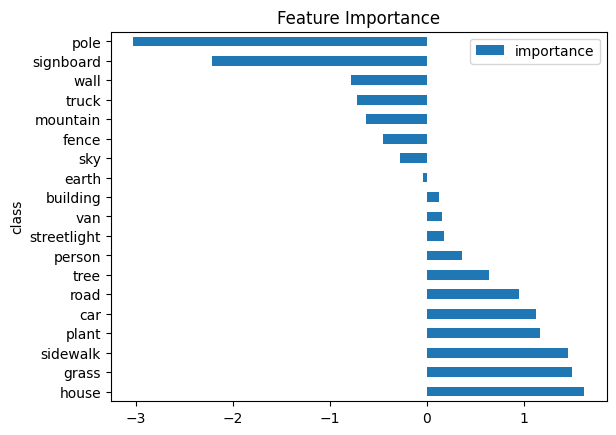

In [56]:
feat_importances.iloc[:20,:].plot(kind='barh',title = 'Feature Importance')

<Axes: title={'center': 'Feature Importance'}, ylabel='class'>

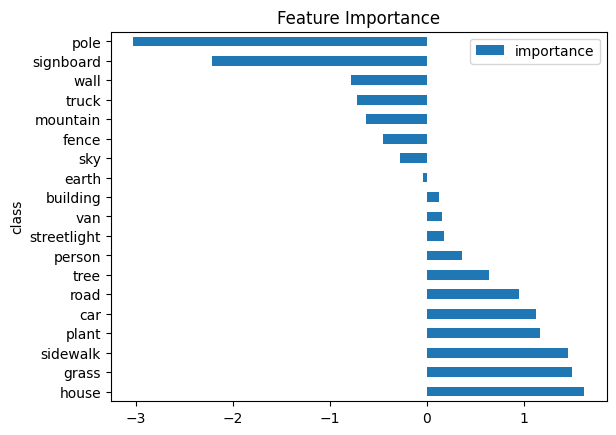

In [57]:
feat_importances.iloc[-20:,:].plot(kind='barh',title = 'Feature Importance')